<a href="https://colab.research.google.com/github/phsimon/LSTM_Last.fm/blob/main/LSTM/target_one_lastFM_1k_LSTM_Embeddings_multilabel_session_dataset_filtered_item.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides a recommender engine and use lastFM 1k  dataset (a filtered and sampled one)
The Recurrent model is built as follow:


*  Input Layer: a sequence (len = max_sequence_train) of songid representing the history of the user

*   Embedding Layer: this layer expand each songid in a higher dimension (embedding size) - now each song of the sequence is represented by a vector of floats
*   Recurrent Layer: this layer process the embedding layer to product a sequence of vector (size: the number of unit of the recurrent layer). We can stack many reccurent layer. as it is reccurent layer, for one sequence, the "n" output take into account the "n-1" output. As we want to have only one vector in output, we set "return_sequence=False.

*   (Dense) Layer : this layer outputs a vecteur whom size is the size of the catalog. "Softmax" is used to identify the highest value and output the index. so that with Softmax, this layer output a prediction




# initialization, model definition

In [ ]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
import keras
print(keras.__version__)

2.3.1


Using TensorFlow backend.


In [ ]:
#init dico for saving results
average_measure={}
average_measure['PREC'],average_measure['MAP'], average_measure['MRR'],average_measure['NDCG'],average_measure['recall'] =[],[],[],[],[]

In [ ]:
# paramètres
batchsize=64
Shift=1
max_sequence_label=1
max_sequence_train=10
num_prediction=10
THRESHOLD_HISTORY=2*max_sequence_train-1
THRESHOLD_ITEM=19
outlier_excluded=0
ratio_sampling_top=1

In [ ]:
# function and procedure
import datetime
from time import time
from keras.layers import Input, Dense, Dropout, TimeDistributed
from keras.utils import np_utils, plot_model,Sequence
from keras.models import Model
from keras.layers import Embedding
from keras.layers import Flatten, Reshape, Permute
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU,SimpleRNN,ConvLSTM2D
from keras.callbacks import EarlyStopping,TensorBoard
import tensorflow as tf
import keras.backend as K

import numpy as np
 
def custom_precision(y_true,y_pred):
    z=tf.cast(y_true,tf.int64)
    index_prediction=tf.nn.top_k(y_pred,k=num_prediction)
    index_target=tf.nn.top_k(z,k=num_prediction)
    true_positive=tf.sets.intersection(index_prediction.indices,index_target.indices)
    precision=tf.count_nonzero(true_positive.values)
    precision_summary=tf.cast(precision,tf.float32)
    return precision_summary/(num_prediction*batchsize)

def build_model(one_hot_size,sequence_size,k_reg=None,b_reg=None,r_reg=None,o_reg=None):
    '''
    '''
    main_input=Input(shape=(sequence_size,),dtype='float32',name='main_input')
    print(main_input.shape)
    # This embedding layer will encode the input sequence
    b = Embedding(output_dim=embedding_size, input_dim=one_hot_size+1,name='my_embeddings')(main_input)
    print("embedding shape {} and type {} ".format(b.shape,type(b)))
    
    c=LSTM(LSTM_size,dropout=dropout_lstm_value,name='my_LSTM', kernel_regularizer=None, bias_regularizer=None,activity_regularizer=None, recurrent_regularizer=r_reg, return_sequences=False)(b)
    #c=LSTM(LSTM_size,dropout=dropout_lstm_value,name='my_LSTM_2', kernel_regularizer=None, bias_regularizer=None,activity_regularizer=None, recurrent_regularizer=r_reg, return_sequences=False)(c)
    d=Dense(one_hot_size,activation='sigmoid')(c)
    #d=TimeDistributed(Dense(one_hot_size,activation='sigmoid'))(c)
   
    model=Model(inputs=main_input, outputs=d)
    #model.compile(optimizer='rmsprop', loss="binary_crossentropy", metrics=['binary_accuracy',custom_precision])
    model.compile(optimizer='rmsprop', loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
    return model


def LastFM_vectorize_sequence(sequence,dimension,liste_item_sorted):
    '''
        :param: sequences : list liste d'ids de films
        :param: dimension : int nombre de films possible (taille du vocabulaire)
        :param: liste_item_sorted: liste des itemids triés par ordre croissant
        :return:results liste de taille dimension (contentant des 1 au rang d'un film vu)
    '''
    result=np.zeros((dimension,1))
    
    # on ordonne la sequence
    # en fait ce n'est pas utile
    # sequence.sort()
    for StockCode in sequence:
        result[liste_item_sorted.index(StockCode)]=1    
    return result   

def LastFM_normalize_liste(vector,norme=1.0):
    '''
        :param: vector : list liste de 0 avec des 1 à chaque fois qu'un film a été vu
        :param: norme : int valeur max de la somme des valeurs du vecteur après normalisation
        :return:results liste normalisée (avec des quotients à la place des 1 dès qu'il y en a plus de un, de manière à ce que la somme fasse 1 )
    '''
    len_vector=len(vector)
    for i in range(len_vector):
        vector[i]/=float(norme)/float(len_vector)    
    return vector   

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, data_source, list_IDs, labels, batch_size=batchsize, dim_train=(max_sequence_train,), dim_label=(max_sequence_label,),n_channels=1,
                 n_classes=0, shuffle=True):
        'Initialization'
        self.data_source=data_source
        self.dim_train = dim_train
        self.dim_test=dim_label
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        #print("number of users per epoch \n",len(self.list_IDs))
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, self.dim_train),dtype=int)
        if max_sequence_label>1:
          y = np.zeros((self.batch_size, self.dim_test,1), dtype=int)
        else:
          y = np.zeros((self.batch_size, self.dim_test), dtype=int)  
        # Generate data
        #print("X shape",X.shape)
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.data_source[ID]
            
            # Store class
            if max_sequence_label > 1:
              generated_label=np.reshape(self.labels[ID],(max_sequence_label,1))
            else:
              generated_label=np.reshape(self.labels[ID],(max_sequence_label,))  
            y[i] = generated_label
 
        return X, y



# Data loading - change the path accordingly

In [ ]:
import pandas as pd

In [ ]:
my_path="/content/drive/My Drive/ColabNotebooks/publication/publi_github/"

testfile="publi-lastfm-1k_session-based_records_test.csv"
trainfile="publi-lastfm-1k_session-based_records_train.csv"



In [ ]:
# lecture des fichiers 
data_train=pd.read_csv(my_path+trainfile,header=0,dtype='int32')
data_test=pd.read_csv(my_path+testfile,header=0,dtype='int32')


In [ ]:
# echantillonage pour accélerer les test
data_train=data_train.sample(frac=ratio_sampling_top, replace=False, random_state=1)

In [ ]:
len(data_train)

504215

In [ ]:
nb_user,nb_ligne=data_train.shape
print(nb_user,nb_ligne)

504215 20


#Dataset building
To executed only one time (take time...) - see further for restore/save file 

*   If intermediate file already generated by a previous execution or another notbook: do not run



## List of items of the whole dataset

In [ ]:
# Building the item set
liste_item_1=[]
liste_item_2=[]
for user in data_train.index:
  liste_item_1.append(data_train.loc[user])
for user in data_test.index:
  liste_item_1.append(data_test.loc[user])
for x in liste_item_1:
  for y in x:
    liste_item_2.append(y)

print(len(liste_item_2))


12615480


(array([10267556.,   682925.,   229990.,   181549.,   191260.,   137814.,
          123171.,   118380.,    75371.,    74642.,    51813.,    47540.,
           45712.,    45809.,    40736.,    32759.,    28469.,    25459.,
           26368.,    21447.,    25705.,    18496.,    17475.,    19698.,
           17518.,    15122.,    13369.,    14286.,    13122.,    11919.]),
 array([    0. ,  3142.8,  6285.6,  9428.4, 12571.2, 15714. , 18856.8,
        21999.6, 25142.4, 28285.2, 31428. , 34570.8, 37713.6, 40856.4,
        43999.2, 47142. , 50284.8, 53427.6, 56570.4, 59713.2, 62856. ,
        65998.8, 69141.6, 72284.4, 75427.2, 78570. , 81712.8, 84855.6,
        87998.4, 91141.2, 94284. ]),
 <a list of 30 Patch objects>)

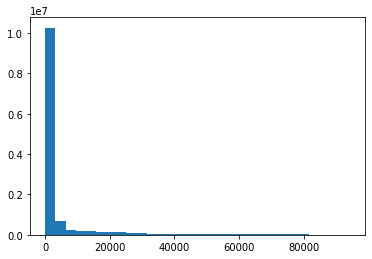

In [ ]:
import matplotlib.pyplot as plt
#plt.hist(liste_item_2,range=(1,20000),bins=1000)
plt.hist(liste_item_2,bins=30)


## Filter the dataset by keeping only item viewed at least THRESHOLD_ITEM times

In [ ]:
from collections import Counter
ma_liste=Counter(liste_item_2).most_common()
ma_liste=ma_liste[1:] # on ne prend pas zero...
topn=[x[0] for x in ma_liste if x[1] > THRESHOLD_ITEM]
histo_topn=[x[1] for x in ma_liste]

In [ ]:
len(topn)

20362

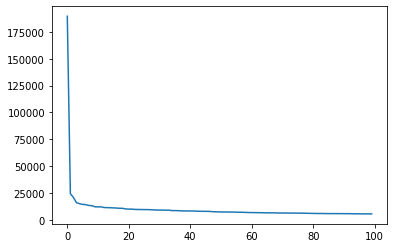

In [ ]:
plt.plot(histo_topn[:100])


In [ ]:
topn_tri=sorted(list(set(topn)))

In [ ]:
ma_liste[:10]

[(28, 189666),
 (13, 24272),
 (349, 20719),
 (80, 15798),
 (602, 14941),
 (717, 14243),
 (840, 14060),
 (77, 13299),
 (817, 13060),
 (1814, 12033)]

In [ ]:
# filter dataset to retain only topn item in data_train
data_train_topn=[]
only_topn=[]
for user in data_train.index:
  history=data_train.loc[user]
  only_topn=[x for x in history if x in topn_tri[outlier_excluded:]]
  while len(only_topn) < len(history):
    only_topn+=[0]
  data_train_topn.append(only_topn)  
data_train_topn=pd.DataFrame(data_train_topn)
print(data_train_topn.head())



      0      1      2      3      4      5      6   ...  13  14  15  16  17  18  19
0   1421   3604   4568  14586   5831   1638   2114  ...   0   0   0   0   0   0   0
1  14256    139  23455    104    139      0      0  ...   0   0   0   0   0   0   0
2  55952  19241  16421     28  19283  37728  13925  ...   0   0   0   0   0   0   0
3   6027  10267   6881   2749   2057  10387  26792  ...   0   0   0   0   0   0   0
4    938   2744   3673   2581      0      0      0  ...   0   0   0   0   0   0   0

[5 rows x 20 columns]


In [ ]:
# filter dataset to retain only topn item in data_set
data_test_topn=[]
only_topn=[]
for user in data_test.index:
  history=data_test.loc[user]
  only_topn=[x for x in history if x in topn_tri[outlier_excluded]]
  while len(only_topn) < len(history):
    only_topn+=[0]
  data_test_topn.append(only_topn)  
data_test_topn=pd.DataFrame(data_test_topn)
print(data_test_topn.head())

TypeError: ignored

In [ ]:
liste_item_tri=sorted(list(set(liste_item_2)))
liste_item_tri.remove(0)
print(len(liste_item_tri))

## Tranlation of itemid into integer

In [ ]:
# re_index the content to have the lowest number so that one-hot will be smaller
song_2_int={i:j+1 for j,i in enumerate(liste_item_tri)}
int_2_song={(i+1):j for i,j in enumerate(liste_item_tri)}
liste_item_tri_int=[song_2_int[k] for k in liste_item_tri]

In [ ]:
song_2_int[1000]
int_2_song[992]

In [ ]:
# re_index the content to have the lowest number so that one-hot will be smaller
song_topn_2_int={i:j+1 for j,i in enumerate(topn_tri)}
int_2_song_topn={i+1:j for i,j in enumerate(topn_tri)}
topn_tri_int=[song_topn_2_int[k] for k in topn_tri]

In [ ]:
len(song_topn_2_int)

In [ ]:
history_size=[np.count_nonzero(data_train.loc[i]) for i in data_train.index]
len(history_size)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(history_size,range=(0,20),bins=20)

## Remove repetition from the sequences, complete with zero if needed

In [ ]:
history_topn_size=[np.count_nonzero(data_train_topn.loc[i]) for i in data_train_topn.index]
len(history_topn_size)

In [ ]:
#compactage historique pour ne pas avoir de doublon dans le train
data_train_topn_without_doublon=[]
for i in data_train_topn.index:
  history_without_doublon=[]
  history=data_train_topn.loc[i]
  for item in history:
    if item not in history_without_doublon:
       history_without_doublon.append(int(item))
  while len(history_without_doublon) < len(history):
    history_without_doublon+=[0]
  data_train_topn_without_doublon.append(history_without_doublon) 
data_train_topn_without_doublon=pd.DataFrame(data_train_topn_without_doublon)    

In [ ]:
#compactage historique pour ne pas avoir de doublon dans le test
data_test_topn_without_doublon=[]
for i in data_test_topn.index:
  history_without_doublon=[]
  history=data_test_topn.loc[i]
  for item in history:
    if item not in history_without_doublon:
       history_without_doublon.append(int(item))
  while len(history_without_doublon) < len(history):
    history_without_doublon+=[0]
  data_test_topn_without_doublon.append(history_without_doublon)   
data_test_topn_without_doublon=pd.DataFrame(data_test_topn_without_doublon)  

In [ ]:
len(data_train_topn_without_doublon)

In [ ]:
data_train_topn_without_doublon.head()

In [ ]:
plt.hist(history_topn_size,range=(0,20),bins=20)

In [ ]:
history_topn_without_doublon_size=[np.count_nonzero(data_train_topn_without_doublon.loc[i]) for i in data_train_topn_without_doublon.index]
len(history_topn_without_doublon_size)

In [ ]:
plt.hist(history_topn_without_doublon_size,range=(0,20),bins=20)

##Filter sequences of length THRESHOLD_HISTORY (zero not counted)

In [ ]:
data_train_history_20=[data_train.loc[i] for i in data_train.index if np.count_nonzero(data_train.loc[i])>THRESHOLD_HISTORY]
data_train_history_20=pd.DataFrame(data_train_history_20)

In [ ]:
data_train_topn_history_20=[data_train_topn.loc[i] for i in data_train_topn.index if np.count_nonzero(data_train_topn.loc[i])>THRESHOLD_HISTORY]
data_train_topn_history_20=pd.DataFrame(data_train_topn_history_20)

In [ ]:
data_train_topn_without_doublon_history_20=[data_train_topn_without_doublon.loc[i] for i in data_train_topn_without_doublon.index \
                                               if np.count_nonzero(data_train_topn_without_doublon.loc[i])>THRESHOLD_HISTORY]
data_train_topn_without_doublon_history_20=pd.DataFrame(data_train_topn_without_doublon_history_20)

In [ ]:
# sampling
ratio_sampling=1
data_train_history_20=pd.DataFrame(data_train_history_20)
data_train_history_20=data_train_history_20.sample(frac=ratio_sampling, replace=False, random_state=1)
# ré-indexation
data_train_history_20=data_train_history_20.reset_index(drop = True) 

In [ ]:
len(data_train_history_20)

In [ ]:
len(data_train_topn_history_20)

In [ ]:
len(data_train_topn_without_doublon_history_20)

## Building train and validation set

In [ ]:
# definition de data_valid : 10% de l'ensemble de train
ration_validation=0.2
data_valid=data_train_history_20.sample(frac=0.2, replace=False, random_state=1)
data_valid_topn=data_train_topn_history_20.sample(frac=0.2, replace=False, random_state=1)
data_valid_topn_without_doublon=data_train_topn_without_doublon_history_20.sample(frac=0.2, replace=False, random_state=1)

In [ ]:
len(data_valid_topn_without_doublon)

In [ ]:
# defintition du complémentaire qui va être le data_train
index=[x for x in data_train_history_20.index if x not in data_valid.index]
data_train_out_valid=pd.DataFrame([data_train_history_20.loc[x] for x in index])


In [ ]:
# defintition du complémentaire qui va être le data_train_topn
index_topn=[x for x in data_train_topn_history_20.index if x not in data_valid_topn.index]
data_train_out_valid_topn=pd.DataFrame([data_train_topn_history_20.loc[x] for x in index_topn])

In [ ]:
# defintition du complémentaire qui va être le data_train_topn
index_topn_without_doublon=[x for x in data_train_topn_without_doublon_history_20.index if x not in data_valid_topn_without_doublon.index]
data_train_out_valid_topn_without_doublon=pd.DataFrame([data_train_topn_without_doublon_history_20.loc[x] for x in index_topn_without_doublon])

In [ ]:
len(data_train_out_valid_topn_without_doublon)

In [ ]:
data_train_out_valid_topn_without_doublon.head()

In [ ]:
#recalcul du nombre d'items différents
# Building the item set
temp_item_1=[]
temp_item_2=[]
for user in data_train_topn_without_doublon_history_20.index:
  temp_item_1.append(data_train_topn_without_doublon_history_20.loc[user])
for user in data_test_topn_without_doublon.index:
  history=data_test_topn_without_doublon
  if np.count_nonzero(history)> THRESHOLD_HISTORY:
    temp_item_1.append(data_test_topn_without_doublon.loc[user])
for x in temp_item_1:
  for y in x:
    temp_item_2.append(y)

print((len(temp_item_2)))


In [ ]:
len(np.unique(temp_item_2))

# Dataset backup/restore/preparation 

*  DATA_SAVED=False will make the dataset to be saved on the repo.
*  DATA_SAVED=True (to be positioned at TRUE after one complete execution of the notebook) the different dataset are retrieved from repository (Dataset Building block above can be skipped) 


In [ ]:
def LastFM_prepare_data_set(dataset,max_sequence_label,max_sequence_train, shuffle, shift):

  '''
      :param: dataset : dataframe : set of user history
      :param: max_sequence_lable : int size of the sequence of label for each user
      :param: max_sequence_train: int size of the sequence of  history to keep for each user
      :param: liste_item_tri: list list of the items within all the dataset (no repetition and sorted by increasing value)
      :return: x_train, x_target_train_oh : array: array of data for train and target
  '''

  # local variables
  sequence_dataset=[]
  sequence_target_dataset=[]
  for user in dataset.index:
      # history

      history=list(dataset.loc[user]) 
      #print("user",user)
      #print("history",history)
      history_int=[song_topn_2_int[songid] for songid in history if songid != 0]
      nb_seq=len(history_int) - (max_sequence_train+max_sequence_label)+1
      for i in range(nb_seq):
        history_4_train=history_int[i:i+max_sequence_train]
        #print("history_4_train",history_4_train)
        #history_4_test=history_int[i+shift:i+shift+max_sequence_label]
        history_4_test=history_int[i+max_sequence_train:i+max_sequence_train+max_sequence_label]
        if shuffle:
          np.random.shuffle(history_4_train)
          #np.random.shuffle(history_4_test)

        sequence_dataset.append(history_4_train) # sous-seq de longueur max_sequence_train
        sequence_target_dataset.append(history_4_test) # item suivant
      



  # padding if necessary
  x_dataset = sequence.pad_sequences(sequence_dataset, maxlen=max_sequence_train)
  x_target_dataset = sequence.pad_sequences(sequence_target_dataset, padding='post',maxlen=max_sequence_label)

  x_dataset=np.array(x_dataset)
  x_target_dataset=np.array(x_target_dataset)
    
  return x_dataset,x_target_dataset



In [ ]:
DATA_SAVED=True

In [ ]:
# sauvegarde dataframe
if not DATA_SAVED:
  #data_train_topn_without_doublon.to_csv(my_path+"target_ten_data_train_topn_without_doublon")
  data_train_out_valid.to_csv(my_path+"target_ten_data_train_out_valid")
  data_train_out_valid_topn.to_csv(my_path+"target_ten_data_train_out_valid_topn")
  data_train_out_valid_topn_without_doublon.to_csv(my_path+"target_ten_data_train_out_valid_topn_without_doublon")
  data_valid.to_csv(my_path+"target_ten_data_valid")
  data_valid_topn.to_csv(my_path+"target_ten_data_valid_topn")
  data_valid_topn_without_doublon.to_csv(my_path+"target_ten_data_valid_topn_without_doublon")
  data_train.to_csv(my_path+"target_ten_data_train")

  data_test.to_csv(my_path+"target_ten_data_test")
  data_test_topn.to_csv(my_path+"target_ten_data_test_topn")
  data_test_topn_without_doublon.to_csv(my_path+"target_ten_data_test_topn_without_doublon")


  # sauvegarde one_hot_size
  import json
  my_details = {'one_hot_size': len(topn_tri_int)}

  with open(my_path+'target_ten_parameter.json', 'w') as json_file:
      json.dump(my_details, json_file)

  # sauvegarde numérotation 
  # conversion dico en dataframe
  import pandas as pd
  df_song_2_int=pd.DataFrame.from_dict(song_2_int,orient='index')
  df_int_2_song=pd.DataFrame.from_dict(int_2_song,orient='index')
  df_song_topn_2_int=pd.DataFrame.from_dict(song_topn_2_int,orient='index')
  df_int_2_song_topn=pd.DataFrame.from_dict(int_2_song_topn,orient='index')

  df_song_2_int.to_csv(my_path+"target_ten_song_2_int")
  df_int_2_song.to_csv(my_path+"target_ten_int_2_song")
  df_song_topn_2_int.to_csv(my_path+"target_ten_song_topn_2_int")
  df_int_2_song_topn.to_csv(my_path+"target_ten_int_2_song_topn")


In [ ]:
def convert_df_2_dict(my_dataframe):
  '''
  '''
  my_dico=my_dataframe.to_dict('split')
  return dict(my_dico['data'])

In [ ]:
import json

if DATA_SAVED:
  with open(my_path+'target_ten_parameter.json') as file:
    parameter_data = json.load(file)
  one_hot_space_size=parameter_data['one_hot_size']  
  #data_train_topn_without_doublon=pd.read_csv(my_path+"target_ten_data_train_topn_without_doublon",index_col=0)
  data_train_out_valid= pd.read_csv(my_path+"target_ten_data_train_out_valid",index_col=0)
  data_train_out_valid_topn=pd.read_csv(my_path+"target_ten_data_train_out_valid_topn",index_col=0)
  data_train_out_valid_topn_without_doublon=pd.read_csv(my_path+"target_ten_data_train_out_valid_topn_without_doublon",index_col=0)
  data_valid=pd.read_csv(my_path+"target_ten_data_valid",index_col=0)
  data_valid_topn=pd.read_csv(my_path+"target_ten_data_valid_topn",index_col=0)
  data_valid_topn_without_doublon=pd.read_csv(my_path+"target_ten_data_valid_topn_without_doublon",index_col=0)
  data_train=pd.read_csv(my_path+"target_ten_data_train",index_col=0)
  data_test=pd.read_csv(my_path+"target_ten_data_test",index_col=0)
  data_test_topn=pd.read_csv(my_path+"target_ten_data_test_topn",index_col=0)
  data_test_topn_without_doublon=pd.read_csv(my_path+"target_ten_data_test_topn_without_doublon",index_col=0)
  # reconstituer les dictionnaire
  song_2_int=pd.read_csv(my_path+"target_ten_song_2_int")
  song_2_int=convert_df_2_dict(song_2_int)
  int_2_song=pd.read_csv(my_path+"target_ten_int_2_song")
  int_2_song=convert_df_2_dict(int_2_song)
  song_topn_2_int=pd.read_csv(my_path+"target_ten_song_topn_2_int")
  song_topn_2_int=convert_df_2_dict(song_topn_2_int)
  int_2_song_topn=pd.read_csv(my_path+"target_ten_int_2_song_topn")
  int_2_song_topn=convert_df_2_dict(int_2_song_topn)
    

In [ ]:
# select dataset
# 1: full 2: threshold history 3: threshold history and item popularity 4: threshold history item popularity and wihout doublon
data_select=4
if data_select==1:
  data_train_in=data_train_out_valid
  data_valid_in=data_valid
elif data_select==2:
  data_train_in=data_train_out_valid
  data_valid_in=data_valid
elif data_select==3:
  data_train_in=data_train_out_valid_topn
  data_valid_in=data_valid_topn
elif data_select==4:
  data_train_in=data_train_out_valid_topn_without_doublon
  data_valid_in=data_valid_topn_without_doublon
else:
  data_train_in=data_train_out_valid
  data_valid_in=data_valid    



## Format data for fitting the model

In [ ]:
# prepare data
##################
SHUFFLE=False
##################
from keras.preprocessing import sequence
#x_train, x_target_train=LastFM_prepare_data_set(data_train,max_sequence_label,max_sequence_train)
x_train,x_target_train=LastFM_prepare_data_set(data_train_in,max_sequence_label,max_sequence_train,shuffle=SHUFFLE,shift=Shift)
x_valid,x_target_valid=LastFM_prepare_data_set(data_valid_in,max_sequence_label,max_sequence_train,shuffle=SHUFFLE, shift=Shift)


In [ ]:
x_target_train.shape

(56760, 1)

In [ ]:

diff_zero=0
for i in range(x_train.shape[0]):
  diff_zero+=np.count_nonzero(x_train[i])

diff_zero/(x_train.shape[0]*x_train.shape[1])

1.0

In [ ]:
for i in range(x_target_train.shape[0]):
  if 0 in x_target_train[i]:
    print(x_target_train[i])


In [ ]:
x_valid.shape

(14190, 10)

In [ ]:
'''while true:
  pass'''

'while true:\n  pass'

In [ ]:
# constitution des dictionnaire selon modélisation https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
#batchsize=128
partition={}
labels={}
partition['train']=list(range(x_train.shape[0]))
partition['validation']=list(range(x_valid.shape[0]))
labels_train={i:j for i,j in enumerate(x_target_train)}
labels_valid={i:j for i,j in enumerate(x_target_valid)}


# one hot encoding pour l'ensemble des items recommandables
if not DATA_SAVED:
  one_hot_space_size=len(topn_tri_int)    
# sinon déjà défini  

#parameter for train data generation
# Parameters
params = {'dim_train': (max_sequence_train),
          'dim_label': (max_sequence_label),
          'batch_size': batchsize,
          'n_classes': one_hot_space_size,
          'n_channels': 1,
          'shuffle': True}

#ipdb.set_trace()
#input("wait")
# Generators
training_generator = DataGenerator(x_train,partition['train'], labels_train, **params)
validation_generator = DataGenerator(x_valid,partition['validation'], labels_valid, **params)

#Training/prediction

##Training model

*   RETRIEVE=True for retrieving an existing model from the repo 
*   After each execution the model is saved on the repo



In [ ]:
# paramètres
from keras.regularizers import L1L2

reco_file="LastFM_LSTM_dico_reco.csv"
LSTM_size=200
epochs=10
embedding_size=100
dropout_lstm_value=0.2
dropout_layer_value=0.0
reg=L1L2(0.01,0.01)


In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model

RETRIEVE=True
# construction du modèle RNN

if not RETRIEVE:

  model=build_model(one_hot_space_size,max_sequence_train,r_reg=reg)
  model.summary()

  start=datetime.datetime.now()
  print("start at :{}".format(str(start)))

  '''es=EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=10)     
  plot_model(model, to_file='model_lstm.png')'''

  history=model.fit_generator(generator=training_generator,validation_data=validation_generator,epochs=epochs,use_multiprocessing=False,verbose=2)
      
  stop=datetime.datetime.now()
  print("elapsed time for training model: {}".format(str(stop-start)))

  # sauvegarde du modèle
  model.save(my_path+'model_LSTM_seq_one'+str(LSTM_size)+'_shift_'+str(Shift)+'_lastFM_history_user_'+str(max_sequence_train)+'_index_start_1.h5')
  print(history.history.keys())
  # summarize history of accuracy
  plt.plot(history.history['sparse_categorical_accuracy'])
  plt.plot(history.history['val_sparse_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

else:
  model=load_model(my_path+'model_LSTM_seq_one'+str(LSTM_size)+'_shift_'+str(Shift)+'_lastFM_history_user_'+str(max_sequence_train)+'_index_start_1.h5')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Méthode non itérative:



*   PRED_WITH_REPETITION = True : on prend le score le plus élevé de chaque vecteur de la séquence de la LSTM (10 vecteurs)
*   PRED_WITH_REPETITION = False : on prend les 10 score les plus élevés du dernier vecteur de la séquence de la LSTM 




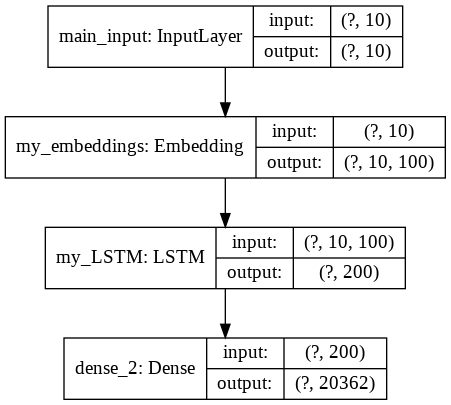

In [ ]:
# affichage model
dot_img_file = my_path+'model_LSTM_targetone'+str(LSTM_size)+'_shift_'+str(Shift)+'_lastFM_history_user_'+str(max_sequence_train)+'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

##init prediction

SHUFFLE_TEST allow to shuffle (True) or not (False) the input sequences which will be used for getting prediction

In [ ]:
# echantillonnage
sample_test_0=[user for user in data_test_topn_without_doublon.index if (user%10<10)]
SHUFFLE_TEST=True

## Predictions

In [ ]:
len(sample_test_0)

126559

In [ ]:
# prediction sur ensemble de test

couverture=[]

count_user=0
count_user_accepted=0
dico_reco={}
check_user=[]
test_input_set=set({})

for userid in sample_test_0:
  # history
  # je ne retiens que les historiques qui ont 20 items
  count_user+=1
  if np.count_nonzero(data_test_topn_without_doublon.loc[userid])>THRESHOLD_HISTORY:
    test_input_set.update(set(data_test_topn_without_doublon.loc[userid][:max_sequence_train]))
    history_int=[song_topn_2_int[k] for k in data_test_topn_without_doublon.loc[userid]]
    count_user_accepted+=1
    check_user.append(userid)
    seq_in=history_int[-(max_sequence_train+num_prediction):-num_prediction] # sous-seq de longueur max_sequence_train
    if SHUFFLE_TEST:
      np.random.shuffle(seq_in)
    count_reco=0
    save_index=history_int[:max_sequence_train]
    while count_reco < num_prediction:
      x = sequence.pad_sequences([seq_in], maxlen=max_sequence_train)
      prediction=model.predict(x)
      # avoid item repetition"
      for index in save_index:
        prediction[0][index]=0
      index_target=np.argmax(prediction[0])
      #print("index_target",index_target)
      save_index.append(index_target)
      couverture.append(index_target)
      if userid in dico_reco:
        dico_reco[userid].append(index_target)
      else:
        dico_reco[userid]=[index_target]    
      seq_in=seq_in[1:]+[index_target]
      count_reco+=1
      
  if count_user%1000 == 0 :
    print(" user {} traité, nb total de users traité: {}".format(userid,count_user))
couverture=np.unique(couverture)
print("nb de user ayant une prediction",len(dico_reco))
print("nb de user pour lesquels on cherche une prediction",count_user)
print("nb de reco <>",len(couverture))

 user 999 traité, nb total de users traité: 1000
 user 1999 traité, nb total de users traité: 2000
 user 2999 traité, nb total de users traité: 3000
 user 3999 traité, nb total de users traité: 4000
 user 4999 traité, nb total de users traité: 5000
 user 5999 traité, nb total de users traité: 6000
 user 6999 traité, nb total de users traité: 7000
 user 7999 traité, nb total de users traité: 8000
 user 8999 traité, nb total de users traité: 9000
 user 9999 traité, nb total de users traité: 10000
 user 10999 traité, nb total de users traité: 11000
 user 11999 traité, nb total de users traité: 12000
 user 12999 traité, nb total de users traité: 13000
 user 13999 traité, nb total de users traité: 14000
 user 14999 traité, nb total de users traité: 15000
 user 15999 traité, nb total de users traité: 16000
 user 16999 traité, nb total de users traité: 17000
 user 17999 traité, nb total de users traité: 18000
 user 18999 traité, nb total de users traité: 19000
 user 19999 traité, nb total de 

In [ ]:
print(count_user_accepted)

1504


In [ ]:
# calcul max_DCG
import math
def log2(x):
 return(math.log(x,2))
max_DCG=0.
for i in range(1,num_prediction+1):
    max_DCG+=(2**(num_prediction+1-i)-1)/log2(i+1)
print("max_DCG",max_DCG)    

max_DCG 1571.4155855572703


In [ ]:
# intermediairy calcul for coverage
train_set_list=[x for y in data_train_out_valid_topn_without_doublon.index for x in data_train_out_valid_topn_without_doublon.loc[y]]
train_set=set(train_set_list)

In [ ]:
# calcul de la précision, sur ensemble de test
tab_AP=[]
precision_at_k=0.
MRR=0.
DCG=0.
max_DCG
count=0  
count_MRR=0 
count_DCG=0
check_user=[]
average_DCG=0
label_set=set({})
new_max_sequence_label=10
for user in sample_test_0:
  if np.count_nonzero(data_test_topn_without_doublon.loc[user])>THRESHOLD_HISTORY:
    count+=1
    check_user.append(user)
    # initialisation des variables
    tab_P=[]
    # calcul du nombre délement en commun rapporté à num_prediction (formule peut poser pb avec les répétition)
    history_int=[song_topn_2_int[k] for k in data_test_topn.loc[user] if k!=0 ]
    if len(np.unique(history_int)) <= THRESHOLD_HISTORY:
      print("len history_int",len(np.unique(history_int)))
      print("history_int",history_int)
    label=history_int[-new_max_sequence_label:]  # on prend les max_sequence_label derniers...ceux d'avant ont été entré pour demander une prédiction
    #print(label)
    label_set.update(set(label))
    #input('wait')
    #retrieved_song_index=set(label)&set(dico_reco[user])
    # car pas de doublon
    retrieved_song=[x for x in dico_reco[user] if x in label]
    #print("retrieved",retrieved_song_index)
    #ipdb.set_trace()

    #precision@(num_prediction) 
    for song_index in retrieved_song:
      precision_at_k+=min(label.count(song_index),dico_reco[user].count(song_index))
    
    
    #AP@k
    # d'après https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832
    P=0
    for rank in range(1,min(num_prediction,len(label))+1):
        # calcul P@rank
        if dico_reco[user][rank-1] in label:
            P+=1.0
            AP_inter=P/rank
            tab_P.append(AP_inter)
        else:
            continue

    if len(retrieved_song)!=0:
        AP=sum(tab_P)/len(retrieved_song)
    else:
        AP=0
    tab_AP.append(AP)  
    
    #MRR
    # see https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832
    for song in dico_reco[user]:
      if song in label:
        MRR+=1.0/(dico_reco[user].index(song)+1)
        count_MRR+=1
        break
      else:
        continue  
    
    #NDCG  
    DCG=0
    for song in dico_reco[user]:
      if song in label:
        DCG+=(2**(num_prediction-label.index(song))-1)/log2(dico_reco[user].index(song)+2)
      else:
        continue
    DCG/=max_DCG
    average_DCG+=DCG    
          
    

  else:
    continue  

print("precision",precision_at_k)
 
precision_at_k=float(precision_at_k)/float(count*num_prediction)
MRR=float(MRR)/float(count)
MAP=sum(tab_AP)/len(tab_AP)
average_DCG=float(average_DCG)/float(count)

print("nb d'items <> dans le label set : {}".format(len(label_set)))
print("precision at {} sur ensemble de train complet égale à {}".format(num_prediction,precision_at_k))
print("nommbre de user sur lequel la precision peut être calculé : {}".format(count))
print("MRR sur ensemble de train complet égale à {}".format(MRR))
print("nombre de user sur lesquel MRR peut être calculé : {}".format(count_MRR))
print("MAP sur ensemble de train complet égale à {}".format(MAP))
print("nommbre de user sur lequel MAP peut être calculé : {}".format(len(tab_AP)))
print("NDCG sur ensemble de train complet égale à {}".format(average_DCG))
print("nommbre d'item pour lequel DCG peut être calculé : {}".format(count))
print("couverture_ coverage: {}".format(len(couverture)/len((test_input_set)|(train_set))))


print("nombre de user pris en compte : {}".format(count))

precision 546.0
nb d'items <> dans le label set : 4755
precision at 10 sur ensemble de train complet égale à 0.0363031914893617
nommbre de user sur lequel la precision peut être calculé : 1504
MRR sur ensemble de train complet égale à 0.1431497488179668
nombre de user sur lesquel MRR peut être calculé : 424
MAP sur ensemble de train complet égale à 0.13758856453337823
nommbre de user sur lequel MAP peut être calculé : 1504
NDCG sur ensemble de train complet égale à 0.027766338865505766
nommbre d'item pour lequel DCG peut être calculé : 1504
couverture_ coverage: 0.0038095238095238095
nombre de user pris en compte : 1504


In [ ]:
average_measure['PREC'].append([SHUFFLE_TEST,round(precision_at_k,4)])
average_measure['MAP'].append([SHUFFLE_TEST,round(MAP,4)])
average_measure['MRR'].append([SHUFFLE_TEST,round(MRR,4)])
average_measure['NDCG'].append([SHUFFLE_TEST,round(average_DCG,4)])
average_measure['recall'].append([SHUFFLE_TEST,round(len(couverture)/len(label_set),4)])

In [ ]:
average_measure

{'MAP': [[False, 0.1374], [True, 0.1376]],
 'MRR': [[False, 0.1424], [True, 0.1431]],
 'NDCG': [[False, 0.0273], [True, 0.0278]],
 'PREC': [[False, 0.0375], [True, 0.0363]],
 'recall': [[False, 0.008], [True, 0.0088]]}

#Annexes

## Store dico recommendation
To be able to compare later two differents dict of recommendations (for instance shuffle and not shuffle)
Hence should be executed one time and skipped the second one


In [ ]:
import copy
dico_reco_sav=copy.deepcopy(dico_reco)

##Overlap between shuffle and not shuffle

In [ ]:
tab_count=[]
for user in dico_reco:
  # all reco being uniques we can use set without losing information
  tab_count.append(len(set(dico_reco[user])&(set(dico_reco_sav[user]))))

overlap=np.average(tab_count)/num_prediction

(array([   0.,    0.,    0.,    0.,    0., 1504.,    0.,    0.,    0.,
           0.]),
 array([ 9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5]),
 <a list of 10 Patch objects>)

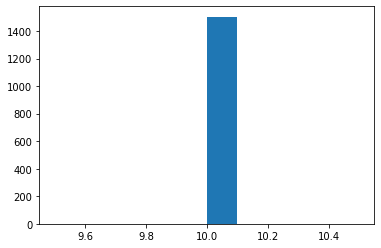

In [ ]:
import matplotlib.pyplot as plt
plt.hist(tab_count)

In [ ]:
print("overlap average",np.average(tab_count))

overlap average 10.0


## Calculation of common items between datasets...

In [ ]:
set_data_train_out_valid_topn_without_doublon=set({})
for index in range(data_train_out_valid_topn_without_doublon.shape[0]):  # index de ligne
  set_data_train_out_valid_topn_without_doublon.update(set(list(data_train_out_valid_topn_without_doublon.iloc[index])))

In [ ]:
len(set_data_train_out_valid_topn_without_doublon)

10414

In [ ]:
set_data_valid_topn_without_doublon=set({})
for index in range(data_valid_topn_without_doublon.shape[0]):  # index de ligne
  set_data_valid_topn_without_doublon.update(set(list(data_valid_topn_without_doublon.iloc[index])))

In [ ]:
len(set_data_valid_topn_without_doublon)

6039

In [ ]:
len(set_data_valid_topn_without_doublon&set_data_train_out_valid_topn_without_doublon)

5277

In [ ]:
set_data_test_topn_without_doublon_20=set({})
for index in range(data_test_topn_without_doublon.shape[0]):  # index de ligne
  if np.count_nonzero(data_test_topn_without_doublon.iloc[index]) > THRESHOLD_HISTORY:
    set_data_test_topn_without_doublon_20.update(set(list(data_test_topn_without_doublon.iloc[index])))

In [ ]:
len(set_data_test_topn_without_doublon_20)

6515

In [ ]:
len(set_data_valid_topn_without_doublon&set_data_test_topn_without_doublon_20)

3952

## Function for counting repetition

In [ ]:
def count_without_doublon_up_threshold(dataset):
  '''
  '''
  count_short,count_loop=0,0
  tab_len=[]
  tab_compare=[]
  for i in range(len(dataset)):
    seq=dataset.iloc[i]
    if np.count_nonzero(seq) > THRESHOLD_HISTORY:
      count_loop+=1
      tab_len.append(len(np.unique(seq)))
      if len(np.unique(seq)) <= THRESHOLD_HISTORY:      
        count_short+=1
      else:
        tab_compare.append(seq)  
    else:
      continue    
  
  return(count_loop-count_short)    

In [ ]:
count_without_doublon_up_threshold(data_train_out_valid_topn)

6410

In [ ]:
count_without_doublon_up_threshold(data_valid_topn)

685

In [ ]:
len(data_train_out_valid_topn_without_doublon)

5676

In [ ]:
len(data_valid_topn_without_doublon)

1419

Histogram

In [ ]:
def get_histo(dataset):
  '''
  '''
  tab=[]
  for i in range(len(dataset)):
    seq=list(dataset.iloc[i])
    # on veut le nbre d'items unique sans compter les 0 qui ne repréente pas un item
    if 0 in seq:
      tab.append(seq.index(0))
    else:
      tab.append(len(seq))
  return tab    

In [ ]:
tab_len_test=get_histo(data_test_topn_without_doublon)

In [ ]:
0 in list(data_test_topn.iloc[2])

True

In [ ]:
tab_len_test.count(20)

1504

(array([29879., 17704., 12203.,  9347.,  7359.,  6171.,  5104.,  4326.,
         3940.,  3389.,  3102.,  2805.,  2663.,  2609.,  2498.,  2485.,
         2379.,  1890.,  1504.]),
 array([ 2.        ,  2.94736842,  3.89473684,  4.84210526,  5.78947368,
         6.73684211,  7.68421053,  8.63157895,  9.57894737, 10.52631579,
        11.47368421, 12.42105263, 13.36842105, 14.31578947, 15.26315789,
        16.21052632, 17.15789474, 18.10526316, 19.05263158, 20.        ]),
 <a list of 19 Patch objects>)

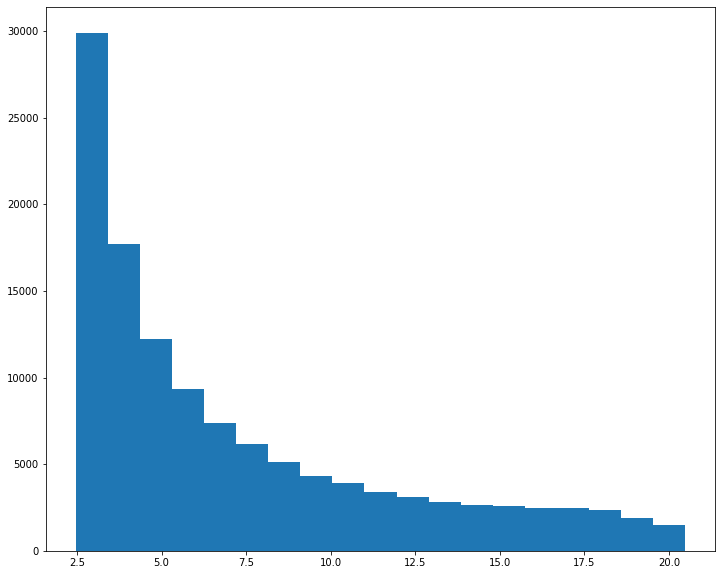

In [ ]:
plt.figure(figsize=(12,10))
plt.hist(tab_len_test,bins=19,range=(2,20),align='right')

In [ ]:
tab=list(data_train_out_valid_topn.iloc[0])
print(tab)
print(list(np.unique(tab)))

[796, 3692, 2060, 14734, 15084, 4030, 80, 4167, 27285, 4812, 4024, 796, 4024, 4056, 61715, 4010, 395, 28554, 395, 796]
[80, 395, 796, 2060, 3692, 4010, 4024, 4030, 4056, 4167, 4812, 14734, 15084, 27285, 28554, 61715]


In [ ]:
len(list(np.unique(tab)))

16

##Backup results

In [ ]:
#stockage des résultats
my_path_publication="/content/drive/My Drive/ColabNotebooks/publication/"

outfile="results.csv"
with open(my_path_publication+outfile, 'a') as f:
  f.write(str(datetime.datetime.now())+'\t'+str(data_select)+'\t'+str(round(precision_at_k,5))+'\t'+str(round(MRR,5))+'\t'+str(round(MAP,5))+'\t'+str(round(average_DCG,5))+\
          '\t'+str(count_user)+'\t'+str(max_sequence_train)+'\t'+str(max_sequence_label)+'\t'+str(THRESHOLD_ITEM)+'\t'+str(THRESHOLD_HISTORY)+'\t'+str(SHUFFLE_TEST)+\
          '\t'+str(LSTM_size)+'\t'+str(epochs)+'\t'+str(embedding_size)+'\t'+str(dropout_lstm_value)+'\t'+str(dropout_layer_value)+'\t'+str(reg)+\
          '\t'+str(ratio_sampling_top)+'\t'+str(num_prediction)+'\t'+str(Shift)+'\t'+str(batchsize)+'\t'+'target_one_lastFM_1k_LSTM_Embeddings_multilabel_session_dataset_filtered_item.ipynb'+'\n')
f.close()

##Inference

In [ ]:
# Filtrage test pour les utilisateurs à historique > 20
data_test_above_20=[]
for i in data_test_topn_without_doublon.index:
  #print(data_test.loc[i])
  if np.count_nonzero(data_test_topn_without_doublon.loc[i])>THRESHOLD_HISTORY:
    data_test_above_20.append(list(data_test_topn_without_doublon.loc[i]))
  

In [ ]:
len_test=len(data_test_above_20)
print(len_test)

1504


In [ ]:
# inférence
couverture=[]
SHUFFLE_TEST=True
dico_inf={}
dico_inf_shuffle={}
#user=np.random.choice(list(range(len_test)),1)[0]
user=1154
print("user",user)
history_int=[song_topn_2_int[k] for k in data_test_above_20[user] if k!=0]
seq_in=history_int[-(max_sequence_train+max_sequence_label):-max_sequence_label] # sous-seq de longueur max_sequence_train
print("seq_in int", seq_in)
if SHUFFLE_TEST:
  np.random.shuffle(seq_in)
save_index=history_int[:max_sequence_train]
count_reco=0
while count_reco < num_prediction:
  x = sequence.pad_sequences([seq_in], maxlen=max_sequence_train)
  prediction=model.predict(x)
  for index in save_index:
    prediction[0][index]=0 
  index_target=np.argmax(prediction[0])
  save_index.append(index_target)
  #print("index_target",index_target)
  couverture.append(index_target)
  if userid in dico_reco:
    dico_reco[userid].append(index_target)
  else:
    dico_reco[userid]=[index_target]    
  seq_in=seq_in[1:]+[index_target]
  print("seq_in",seq_in)
  count_reco+=1

if SHUFFLE:
  dico_inf_shuffle[user]=couverture
elif not SHUFFLE :
  dico_inf[user]=couverture 

print("prediction",couverture)
label=label=history_int[-new_max_sequence_label:]
print("label",label)
print("nb vrais positifs",len(set(couverture)&set(label)))
  

user 1154
seq_in int [2343, 2245, 753, 546, 827, 2350, 711, 703, 20048, 1168]
seq_in [20048, 827, 2245, 711, 2343, 1168, 703, 2350, 753, 25]
seq_in [827, 2245, 711, 2343, 1168, 703, 2350, 753, 25, 510]
seq_in [2245, 711, 2343, 1168, 703, 2350, 753, 25, 510, 495]
seq_in [711, 2343, 1168, 703, 2350, 753, 25, 510, 495, 1588]
seq_in [2343, 1168, 703, 2350, 753, 25, 510, 495, 1588, 293]
seq_in [1168, 703, 2350, 753, 25, 510, 495, 1588, 293, 71]
seq_in [703, 2350, 753, 25, 510, 495, 1588, 293, 71, 744]
seq_in [2350, 753, 25, 510, 495, 1588, 293, 71, 744, 49]
seq_in [753, 25, 510, 495, 1588, 293, 71, 744, 49, 1436]
seq_in [25, 510, 495, 1588, 293, 71, 744, 49, 1436, 1417]
prediction [25, 510, 495, 1588, 293, 71, 744, 49, 1436, 1417]
label [2245, 753, 546, 827, 2350, 711, 703, 20048, 1168, 14086]
nb vrais positifs 0


## Loss study
*   Display Loss for validation

In [ ]:
# étude du loss sur l'ensemble de validation
# les labels sont fournis par le dictionnaire labels_valid
# les predictions sont à construire
from keras import utils
tab_loss=[]
tab_yhat=[]
tab_ytrue=[]

cce = tf.keras.losses.CategoricalCrossentropy()
scce = tf.keras.losses.SparseCategoricalCrossentropy()
for row in validation_generator:
  for i in range(len(row[0])):
    seq=sequence.pad_sequences([row[0][i]], maxlen=max_sequence_train)
    y_hat=model.predict(seq)
    y_true=row[1][i]
    loss=scce(tf.convert_to_tensor(y_true),tf.convert_to_tensor(y_hat[0]))
    tab_loss.append(keras.backend.eval(loss))
    if i == 10:
      break
  break     


In [ ]:
# méthode plus rapide...
tab_loss_log=[]
tab_yhat=[]
tab_ytrue=[]

count=0
for row in validation_generator:
  for i in range(len(row[0])):
    seq=sequence.pad_sequences([row[0][i]], maxlen=max_sequence_train)
    y_hat=model.predict(seq)
    y_true=row[1][i]
    loss=-np.log(y_hat[0][y_true[0]])
    tab_loss_log.append(loss)
    count+=1
  if count%1000 == 0:
    print(count)  
    

8000


(array([2547., 3186., 3065., 2338., 1426.,  891.,  437.,  193.,   51.,
          10.]),
 array([1.0334824e-03, 1.1773461e+00, 2.3536587e+00, 3.5299711e+00,
        4.7062836e+00, 5.8825965e+00, 7.0589089e+00, 8.2352219e+00,
        9.4115343e+00, 1.0587847e+01, 1.1764159e+01], dtype=float32),
 <a list of 10 Patch objects>)

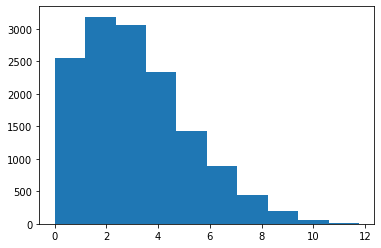

In [ ]:
plt.hist(tab_loss_log)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.0000000e+00, 1.6666667e-06, 3.3333333e-06, 4.9999999e-06,
        6.6666666e-06, 8.3333334e-06, 9.9999997e-06, 1.1666667e-05,
        1.3333333e-05, 1.5000000e-05, 1.6666667e-05, 1.8333334e-05,
        1.9999999e-05, 2.1666667e-05, 2.3333334e-05, 2.4999999e-05,
        2.6666667e-05, 2.8333334e-05, 2.9999999e-05, 3.1666666e-05,
        3.3333334e-05, 3.5000001e-05, 3.6666668e-05, 3.8333332e-05,
        3.9999999e-05, 4.1666666e-05, 4.3333333e-05, 4.5000001e-05,
        4.6666668e-05, 4.8333335e-05, 4.9999999e-05], dtype=float32),
 <a list of 30 Patch objects>)

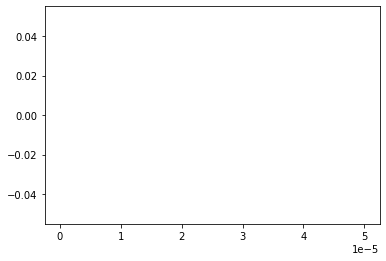

In [ ]:
plt.hist(tab_loss_log,range=(0,5e-5),bins=30)

(array([1.025e+03, 1.251e+03, 1.363e+03, 1.444e+03, 1.508e+03, 1.424e+03,
        1.290e+03, 1.125e+03, 8.310e+02, 7.290e+02, 5.580e+02, 4.620e+02,
        3.660e+02, 2.600e+02, 1.920e+02, 1.360e+02, 8.500e+01, 4.800e+01,
        2.700e+01, 1.200e+01, 5.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([1.00000e-03, 5.34300e-01, 1.06760e+00, 1.60090e+00, 2.13420e+00,
        2.66750e+00, 3.20080e+00, 3.73410e+00, 4.26740e+00, 4.80070e+00,
        5.33400e+00, 5.86730e+00, 6.40060e+00, 6.93390e+00, 7.46720e+00,
        8.00050e+00, 8.53380e+00, 9.06710e+00, 9.60040e+00, 1.01337e+01,
        1.06670e+01, 1.12003e+01, 1.17336e+01, 1.22669e+01, 1.28002e+01,
        1.33335e+01, 1.38668e+01, 1.44001e+01, 1.49334e+01, 1.54667e+01,
        1.60000e+01], dtype=float32),
 <a list of 30 Patch objects>)

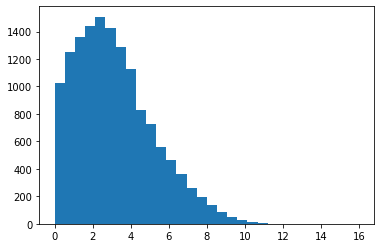

In [ ]:
plt.hist(tab_loss_log,range=(1e-3,16),bins=30)

In [ ]:
from scipy import stats
stats.describe(tab_loss_log)

DescribeResult(nobs=14144, minmax=(0.0010334824, 11.764159), mean=3.15123, variance=4.1771545, skewness=0.735062837600708, kurtosis=0.15099254393622052)

In [ ]:
# moyenne loss par batch
tab_loss_log_mean=[]
nb_batch=int(len(tab_loss_log)/batchsize)
for i in range(nb_batch):
  tab_loss_log_mean.append(np.average(tab_loss_log[i*batchsize:(i+1)*batchsize]))
len(tab_loss_log_mean)

221

In [ ]:
stats.describe(tab_loss_log_mean)

DescribeResult(nobs=221, minmax=(2.4865985, 4.09344), mean=3.15123, variance=0.06413205, skewness=0.36381176114082336, kurtosis=0.4702600111151889)

(array([ 3., 12., 37., 60., 49., 33., 17.,  7.,  2.,  1.]),
 array([2.4865985, 2.6472826, 2.8079667, 2.968651 , 3.1293352, 3.2900193,
        3.4507034, 3.6113875, 3.7720718, 3.932756 , 4.09344  ],
       dtype=float32),
 <a list of 10 Patch objects>)

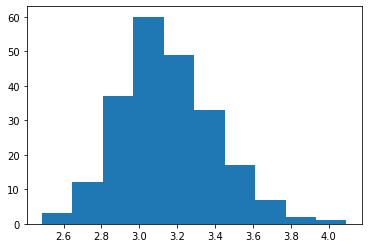

In [ ]:
plt.hist(tab_loss_log_mean)

## Sandbox for calculation on cross entropy

In [ ]:
loss = scce(
  tf.convert_to_tensor([0, 1, 2]),
  tf.convert_to_tensor([[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]]))
print('Loss: ', K.get_value(loss))  # Loss: 0.3239
loss = cce(
  tf.convert_to_tensor([[1,0,0],[0,1,0],[0,0,1]]),
  tf.convert_to_tensor([[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]]))
print('Loss: ', K.get_value(loss))  # Loss: 0.3239

Loss:  0.32396814
Loss:  0.32396814


In [ ]:
import keras.backend as K

test_cce = tf.keras.losses.CategoricalCrossentropy()
test_scce = tf.keras.losses.SparseCategoricalCrossentropy()
tab_labels=[0,1,2,3,4,5,6,7,8,9]
y_true=[0,0,0,1,0,0,0,0,0,0]
y_true_sparse=[3]

y_hat=[[0.22,0.01,0.01,0.7,0.01,0.01,0.01,0.01,0.01,0.01]]
K.eval(test_cce(y_true,y_hat))
K.eval(test_scce(tf.convert_to_tensor(y_true_sparse),tf.convert_to_tensor(y_hat)))


0.35667497

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_true_sparse,y_hat, labels=tab_labels)

0.35667494393873245

In [ ]:
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([48])")

<IPython.core.display.Javascript object>